In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.special import expit


matplotlib.rcParams['figure.dpi'] = 200

## logistic function

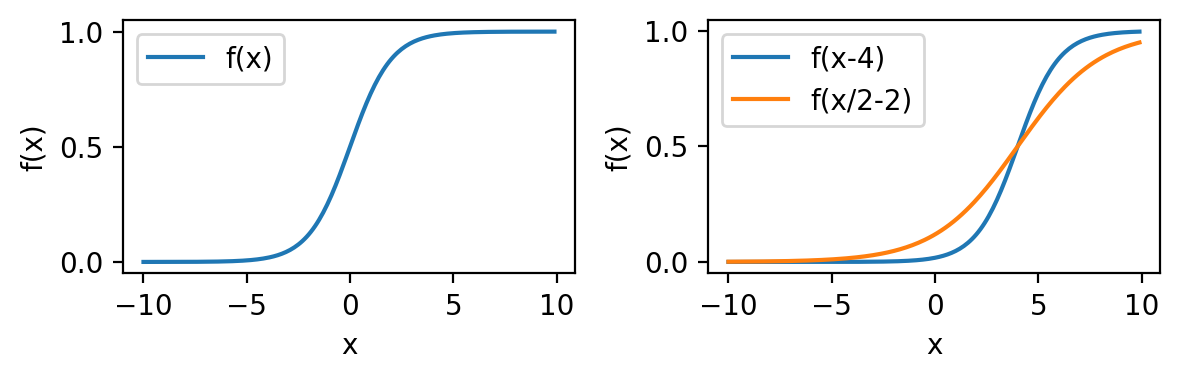

In [2]:
x = np.arange(-10, 10, 0.1)

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(x, expit(x), label='f(x)')
plt.legend()
# plt.annotate(, (-10, 0.8), color='blue')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tight_layout()
plt.savefig('logistic.pdf')
plt.savefig('logistic.png')

plt.subplot(1, 2, 2)
plt.plot(x, expit(x-4), label='f(x-4)')
plt.plot(x, expit(x/2-2), label='f(x/2-2)')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tight_layout()
plt.savefig('logistic.pdf')
plt.savefig('logistic.png')

## Credit Example

This is nice, but we'd need to do log transforms on the variables, apart, perhaps, from Age, which would make the explanation harder. Cleaned version of UCI credit scoring dataset: https://github.com/davidcsterratt/Credit_Shiny  https://nycdatascience.com/blog/student-works/credit-card-approval-analysis/

In [3]:
## Loading and cleaning

credit = pd.read_csv('datasets/Credit_Approval.csv', na_values=['?'])
credit.replace('+', 1, inplace=True)
credit.replace('-', 0, inplace=True)
credit.replace('?', pd.NA, inplace=True)
credit['Gender']=credit['Gender'].replace('a', 0)
credit['Gender']=credit['Gender'].replace('b', 1)
credit['Employed']=credit['Employed'].replace('f', 0)
credit['Employed']=credit['Employed'].replace('t', 1)
credit.dropna(inplace=True)
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          653 non-null    float64
 1   Age             653 non-null    float64
 2   Debt            653 non-null    float64
 3   Married         653 non-null    object 
 4   BankCustomer    653 non-null    object 
 5   EducationLevel  653 non-null    object 
 6   Ethnicity       653 non-null    object 
 7   YearsEmployed   653 non-null    float64
 8   PriorDefault    653 non-null    object 
 9   Employed        653 non-null    int64  
 10  CreditScore     653 non-null    int64  
 11  DriversLicense  653 non-null    object 
 12  Citizen         653 non-null    object 
 13  ZipCode         653 non-null    float64
 14  Income          653 non-null    int64  
 15  Approved        653 non-null    int64  
dtypes: float64(5), int64(4), object(7)
memory usage: 86.7+ KB


In [4]:
## Drop irrelevant (we suppose!) ZipCode
credit.drop(['ZipCode'], 1, inplace=True)

In [5]:
credit.groupby('Gender').mean()

,Age,Debt,YearsEmployed,Employed,CreditScore,Income,Approved
Gender,,,,,,,
0.0,30.760985,5.090591,1.818498,0.487685,2.625616,911.389163,0.467980
1.0,31.838911,4.711767,2.436378,0.417778,2.446667,1059.942222,0.446667


<Figure size 1200x1200 with 0 Axes>

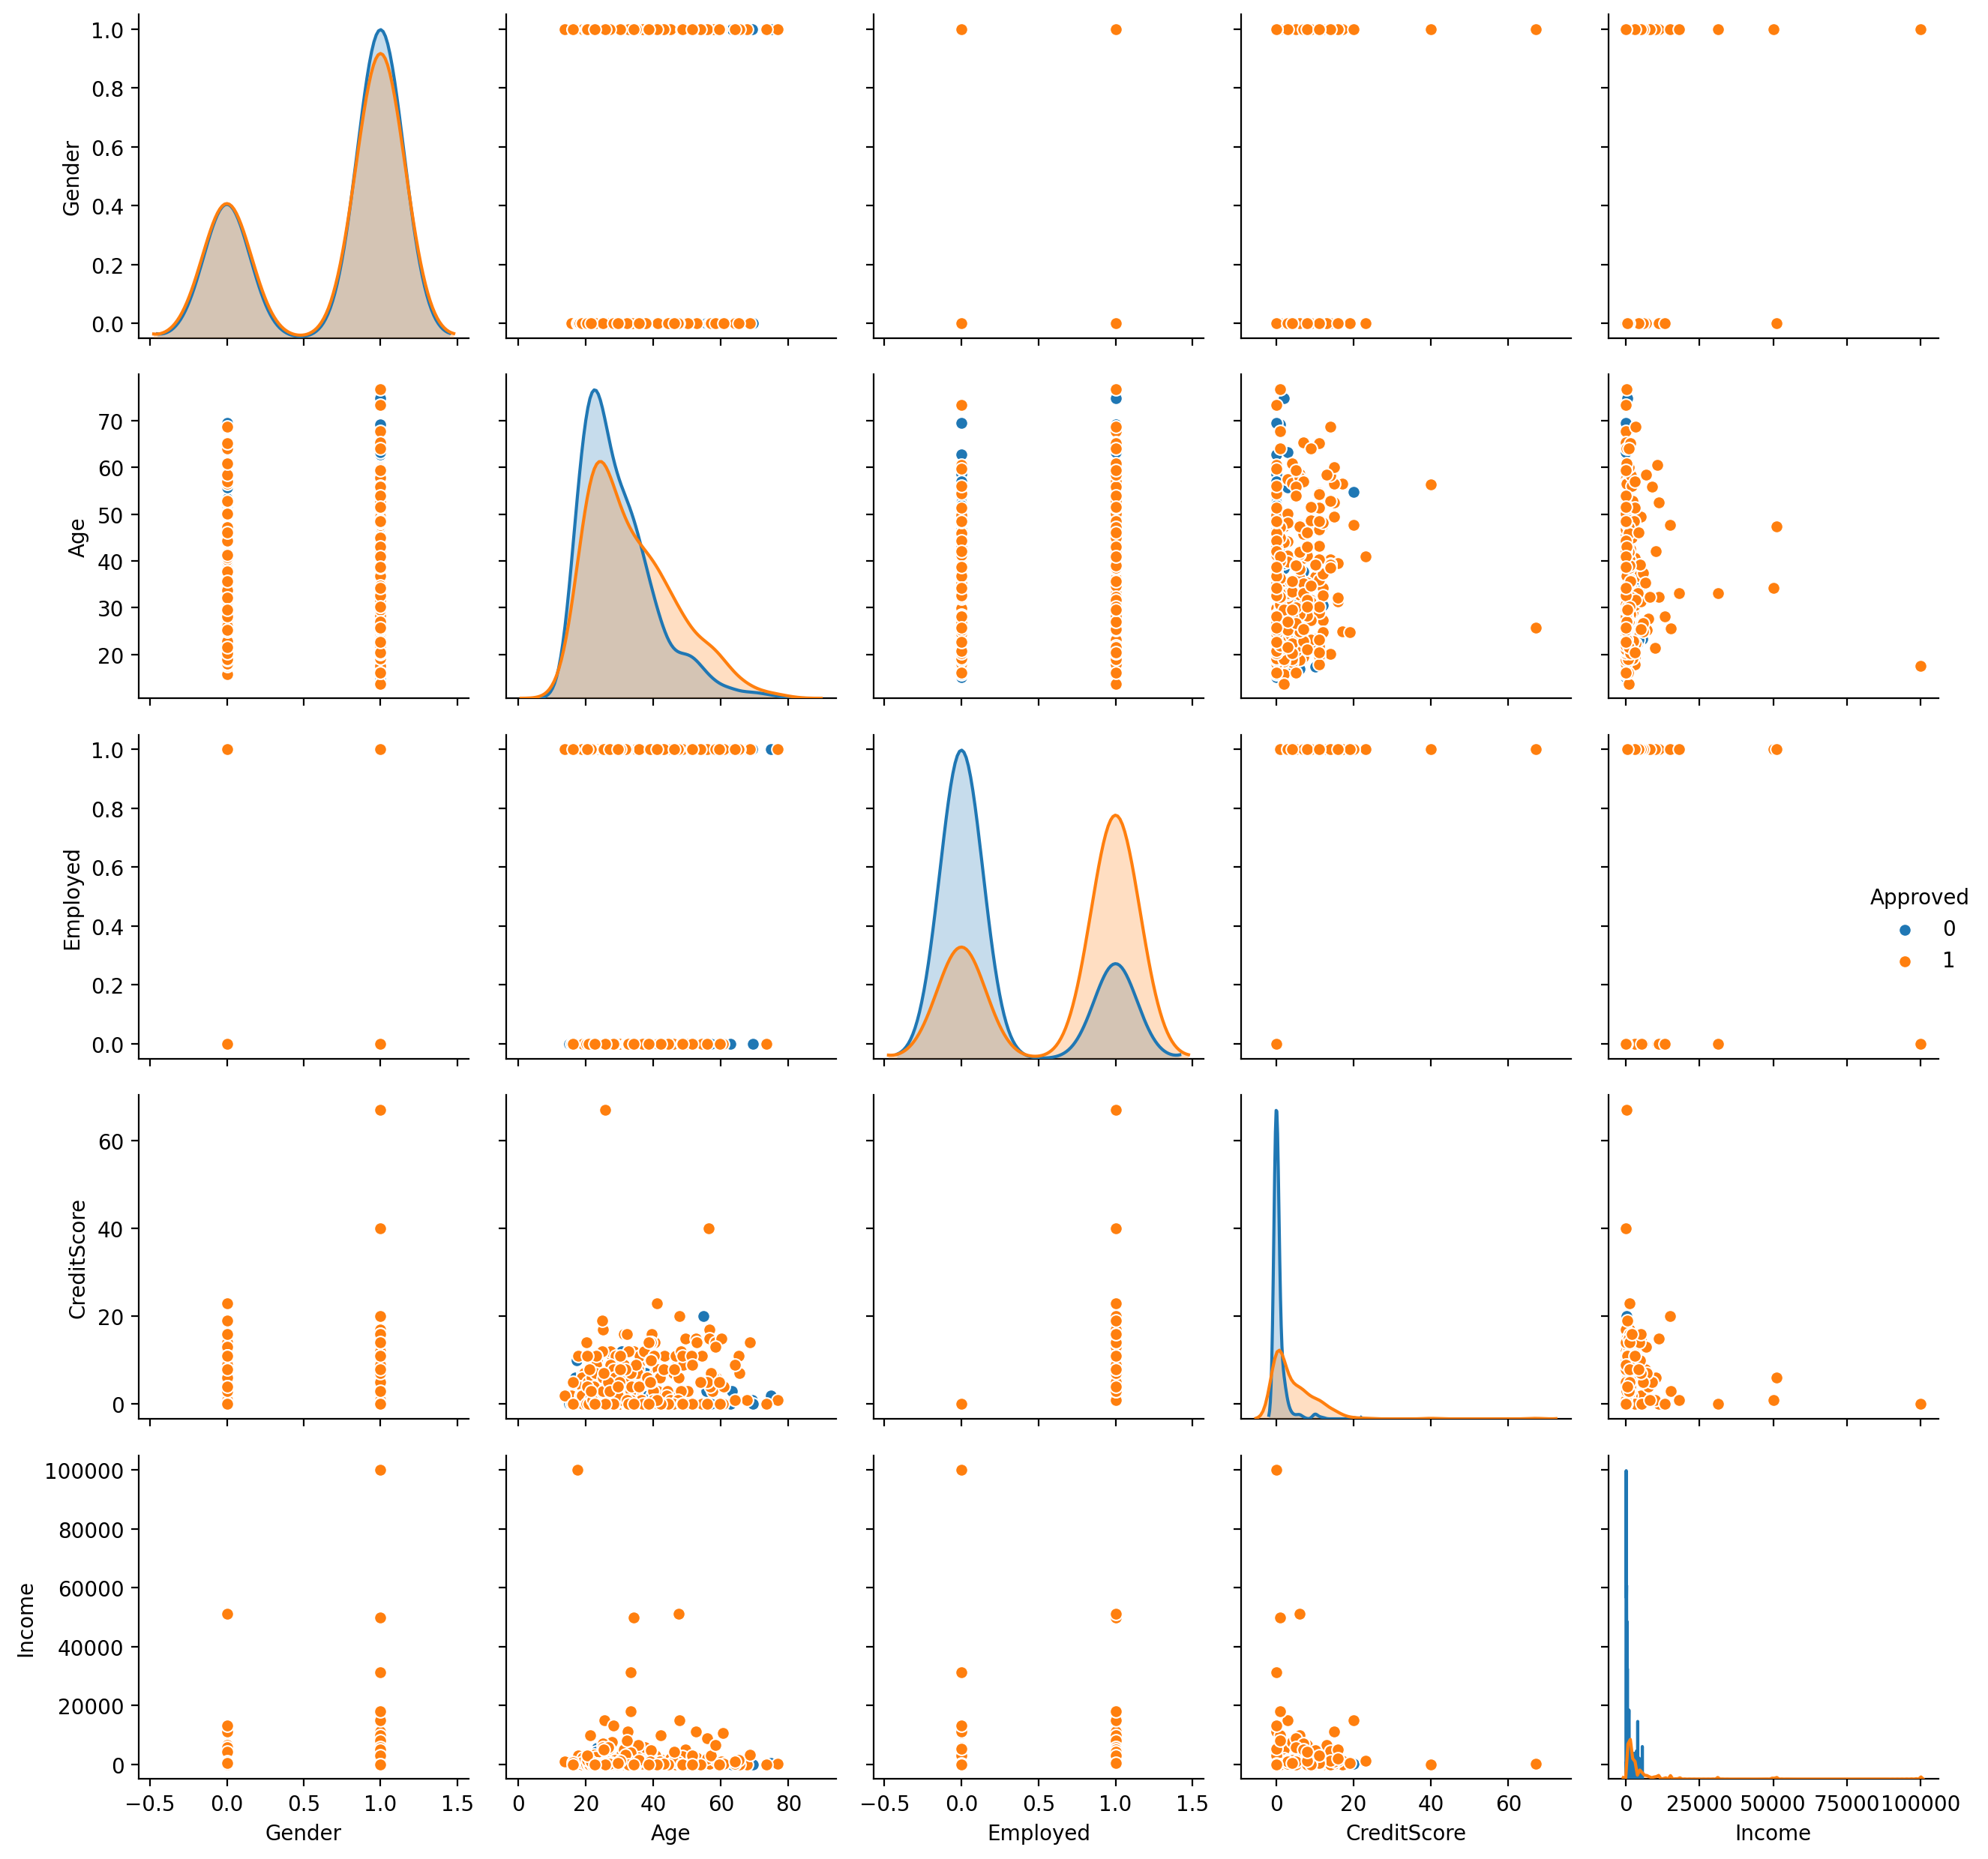

In [6]:
plt.figure(figsize=(6,6))
# sns.set(font_scale=2)
sns.pairplot(credit.drop(['Debt', 'YearsEmployed'], 1), hue='Approved')
# grid_kws=dict(font_scale=10))
plt.tight_layout()
plt.savefig('credit-pairplot.png')

In [7]:
# plt.scatter(np.log(credit['Income']+1), credit['Approved'])
# plt.xlim([0, 5000])
credit['LogIncome'] = np.log10(credit['Income'] + 1)
credit['LogCreditScore'] = np.log(credit['CreditScore'] + 1)
credit.drop(['Income', 'CreditScore'], 1, inplace=True)

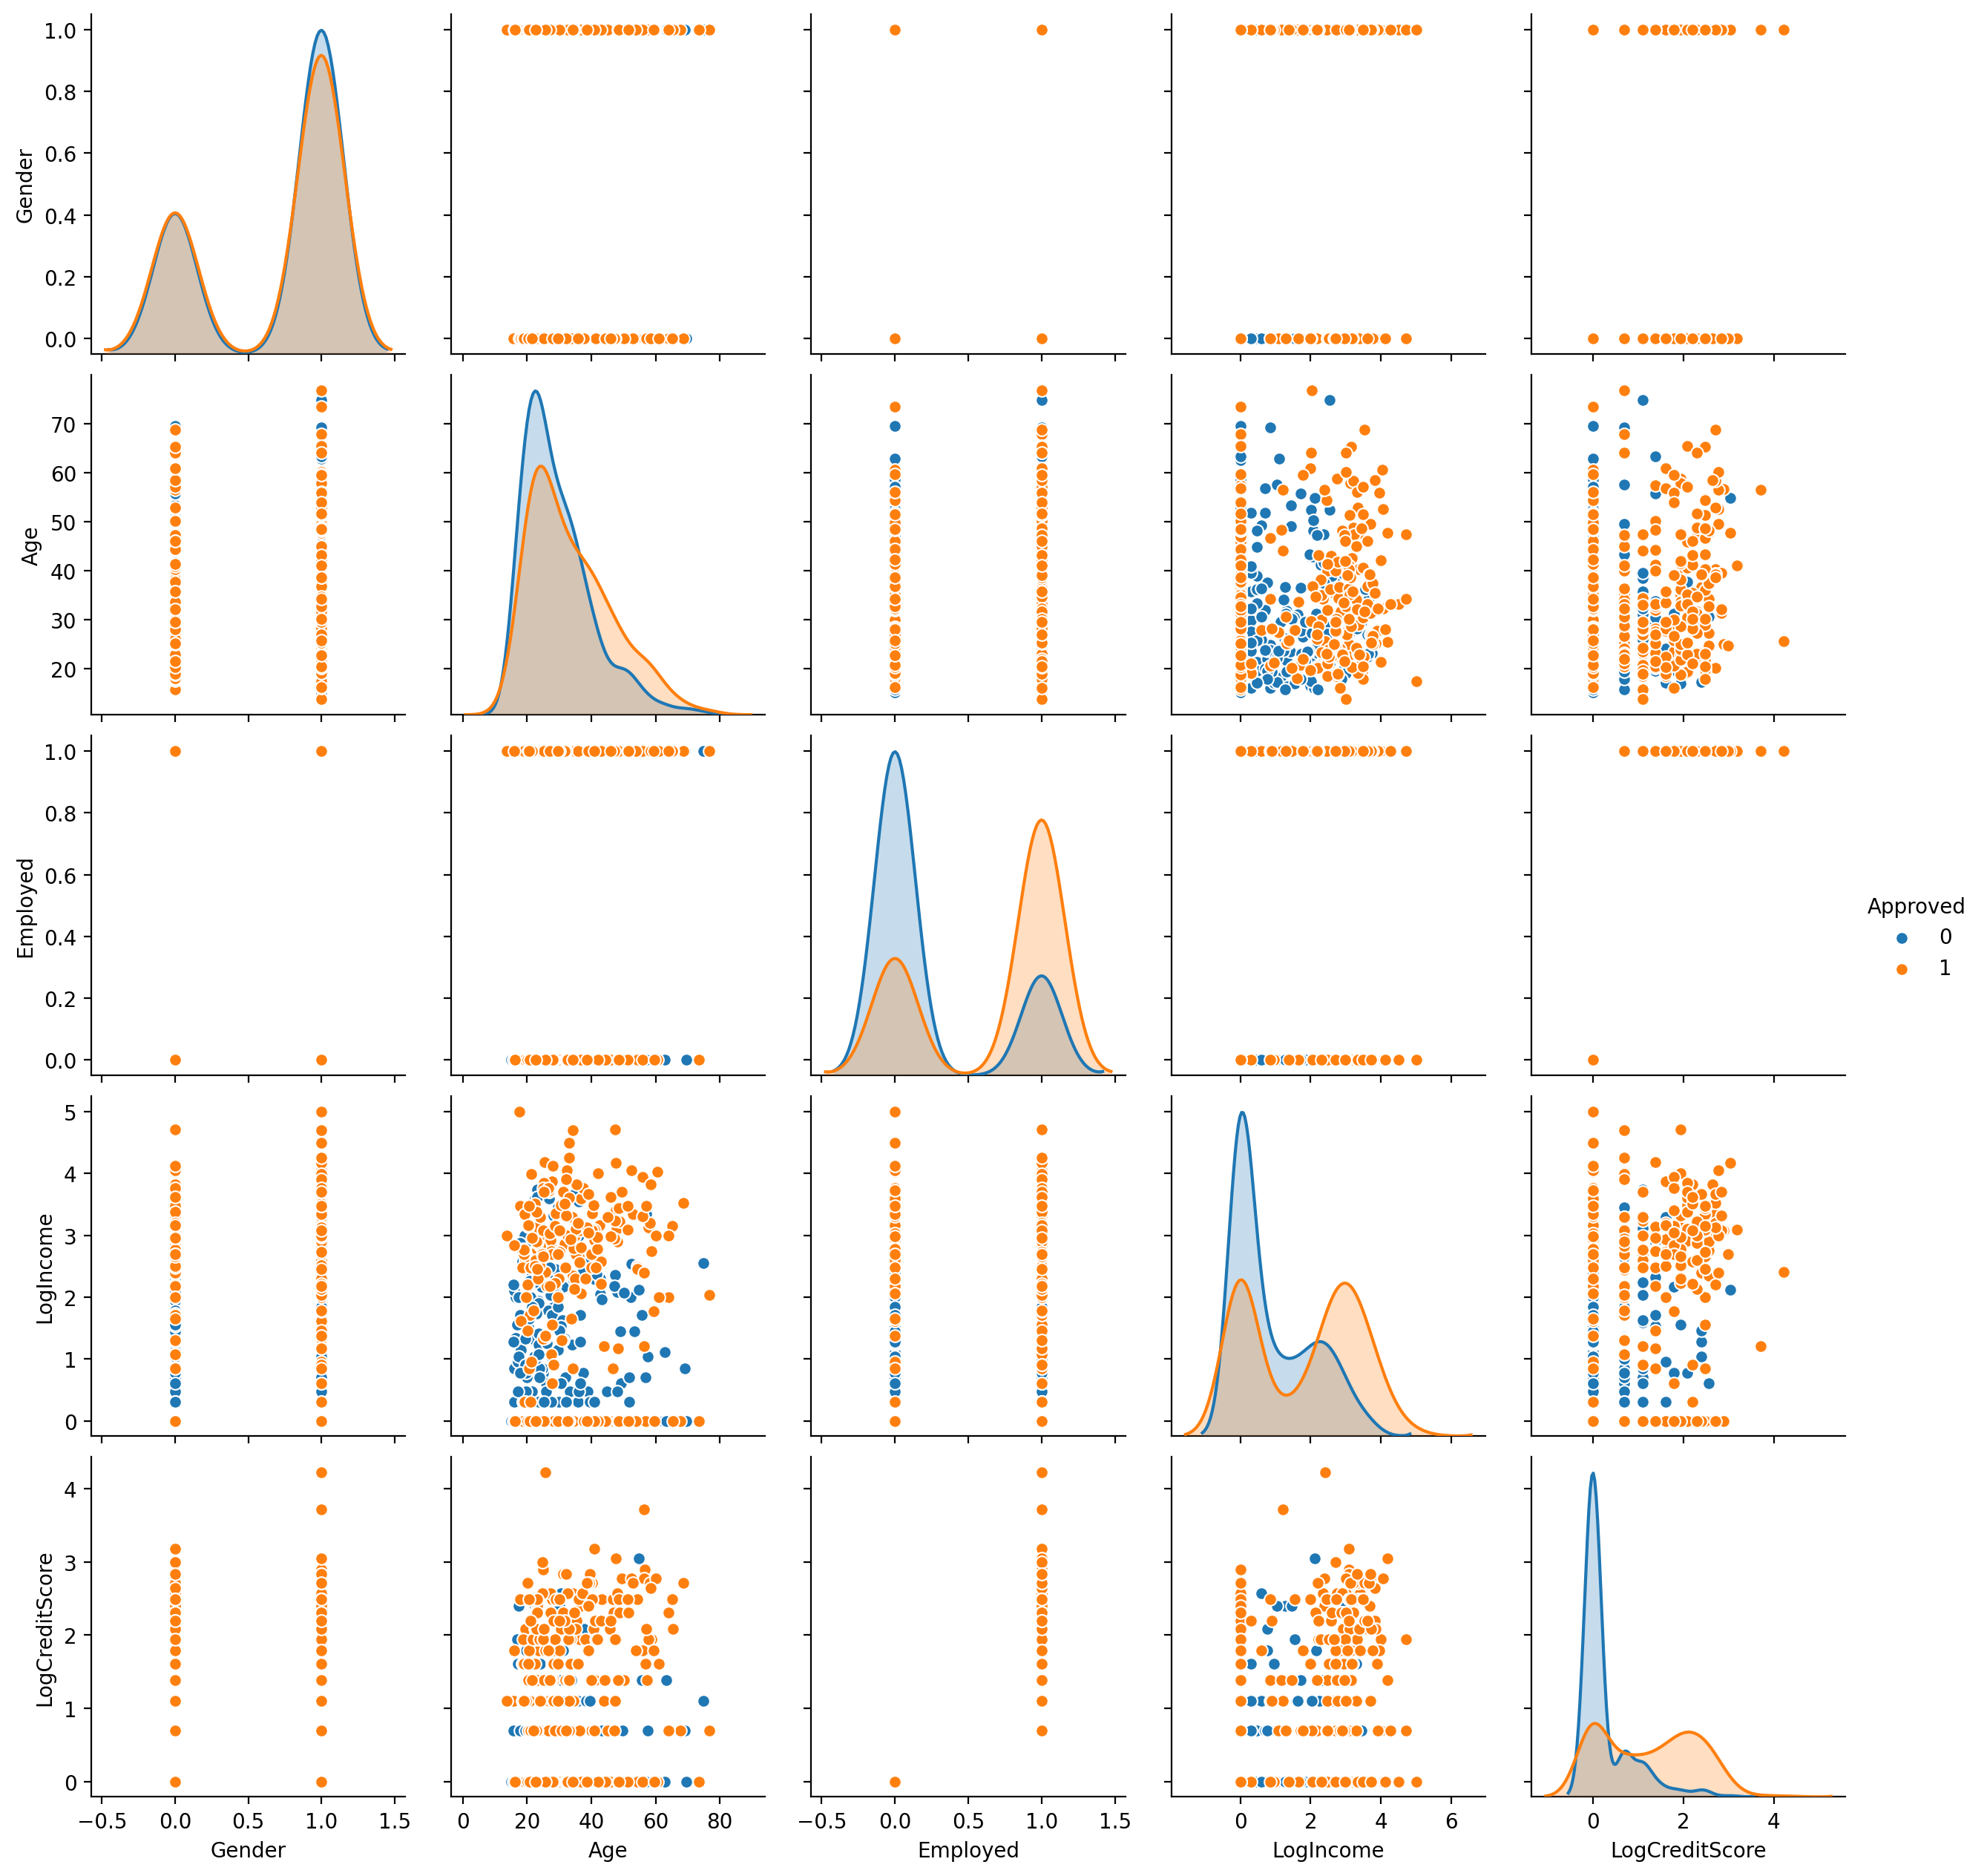

In [8]:
sns.pairplot(credit.drop(['Debt', 'YearsEmployed'], 1), hue='Approved')
plt.savefig('credit-pairplot.png')

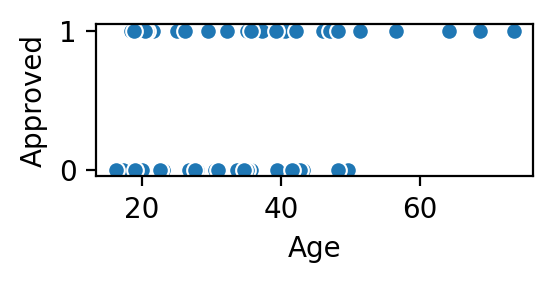

In [9]:
# sns.set(font_scale=1)

credit_sorted = credit.sort_values('Age')
plt.figure(figsize=(3, 1.5))
sns.scatterplot(x='Age', y='Approved', data=credit_sorted.sample(50, random_state=1))
plt.tight_layout()
plt.savefig('credit-age.pdf')
plt.savefig('credit-age.png')

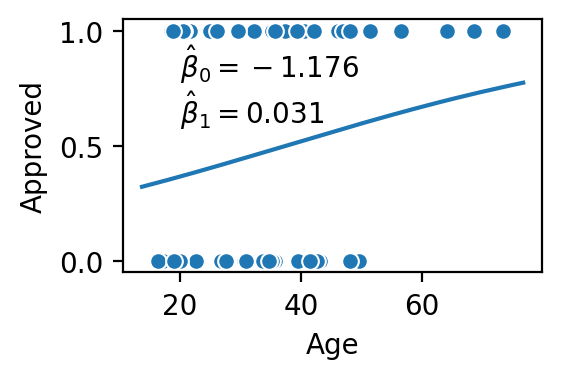

In [10]:
X = credit_sorted[['Age']].to_numpy(copy=True) 
y = credit_sorted['Approved'].to_numpy()
clf = LogisticRegression(random_state=0).fit(X, y)
beta0 = clf.intercept_
beta1 = clf.coef_[0][0]
plt.figure(figsize=(3, 2))

sns.scatterplot(x='Age', y='Approved', data=credit_sorted.sample(50, random_state=1))
plt.plot(X, clf.predict_proba(X)[:,1])
plt.annotate('$\\hat\\beta_0=%2.3f$'%(beta0), (20, 0.8))
plt.annotate('$\\hat\\beta_1=%2.3f$'%(beta1), (20, 0.6))

plt.tight_layout()
plt.savefig('credit-age-lr.pdf')
plt.savefig('credit-age-lr.png')

In [11]:
# np.exp(clf.coef_)
# clf.intercept_/clf.coef_
beta0 = clf.intercept_
beta1 = clf.coef_[0][0]
print('beta_0 = %2.3f; beta_1 = %2.3f; offset = %2.3f'%(beta0, beta1, -beta0/beta1))
print('f(beta_0) = %2.3f'%(expit(beta0)))

clf.coef_

beta_0 = -1.176; beta_1 = 0.031; offset = 37.548
f(beta_0) = 0.236


array([[0.03133242]])

### Employment

In [12]:
contingency_table = credit.pivot_table('Approved', 'Employed')
contingency_table['Not approved'] = 1 - contingency_table['Approved']
contingency_table['Approval odds'] = contingency_table['Approved']/contingency_table['Not approved']
contingency_table.to_latex('credit-employment-contingency.tex', float_format='%2.2f')

In [13]:
odds_ratio = contingency_table.loc[1, 'Approval odds']/contingency_table.loc[0, 'Approval odds']
odds_ratio

7.094086021505375

In [14]:
np.log(odds_ratio)

1.9592614822301773

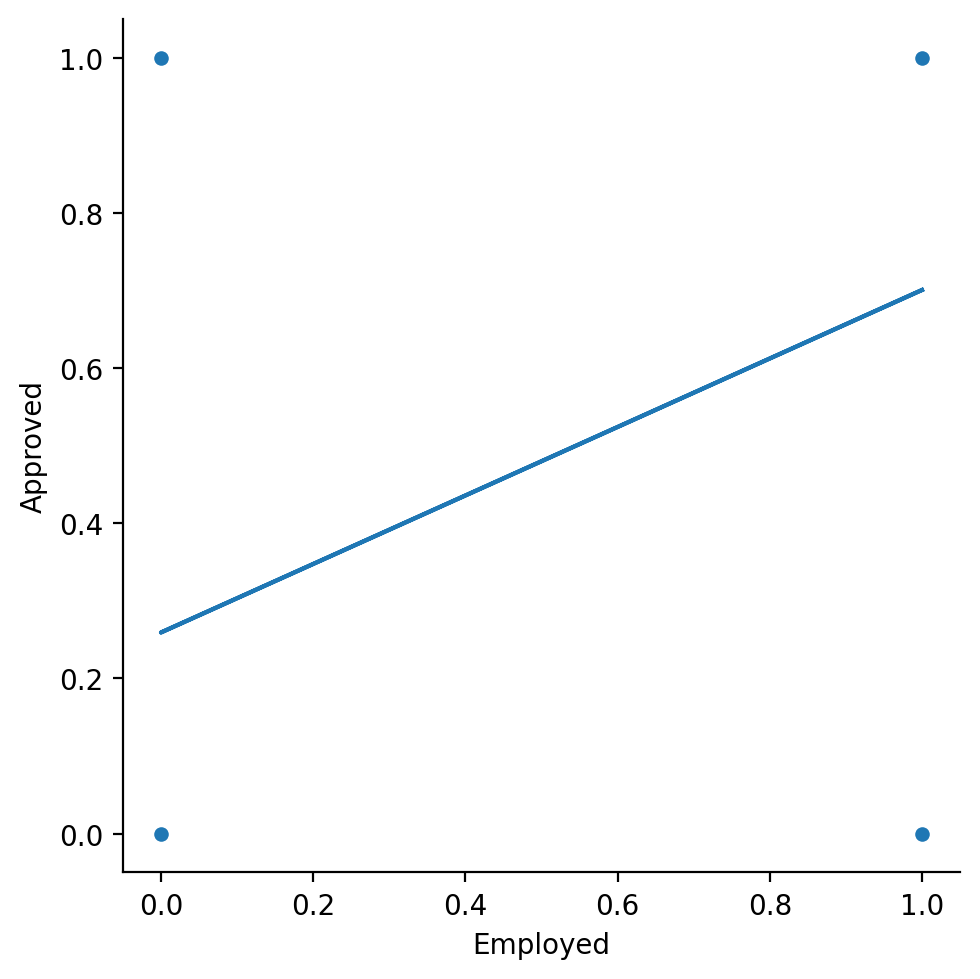

In [15]:
X = credit_sorted[['Employed']].to_numpy(copy=True) 
y = credit_sorted['Approved'].to_numpy()
clf = LogisticRegression(random_state=0).fit(X, y)
sns.relplot(x='Employed', y='Approved', data=credit_sorted.sample(50, random_state=1))
plt.plot(X, clf.predict_proba(X)[:,1])

## Both age and Employed

In [16]:
X = credit_sorted[['Age', 'Employed']].to_numpy(copy=True) 
y = credit_sorted['Approved'].to_numpy()
logr = LogisticRegression(random_state=0).fit(X, y)
np.exp(logr.coef_)[0]
logr.coef_

array([[0.02945963, 1.88133772]])

In [17]:
beta = np.array([logr.intercept_[0], logr.coef_[0][0], logr.coef_[0][1]])
beta

array([-1.96857164,  0.02945963,  1.88133772])

In [18]:
credit_age_employment = pd.DataFrame({'Variable': ['Intercept', 'Age', 'Employed'],
                                      'Coefficient': beta,
                                     'Odds or OR': np.exp(beta)})
credit_age_employment.index=['$\\hat\\beta_0$', '$\\hat\\beta_1$', '$\\hat\\beta_2$']
# credit_age_employment.to_latex('credit-employment-age-coeffs.tex', float_format='%2.3f')
credit_age_employment

,Variable,Coefficient,Odds or OR
$\hat\beta_0$,Intercept,-1.968572,0.139656
$\hat\beta_1$,Age,0.029460,1.029898
$\hat\beta_2$,Employed,1.881338,6.562278


## Age and LogIncome

In [19]:
X = credit_sorted[['Age', 'LogIncome']].to_numpy(copy=True) 
y = credit_sorted['Approved'].to_numpy()
logr = LogisticRegression(random_state=0).fit(X, y)
np.exp(logr.coef_)[0]
logr.coef_
logr.score(X, y)

0.6753445635528331

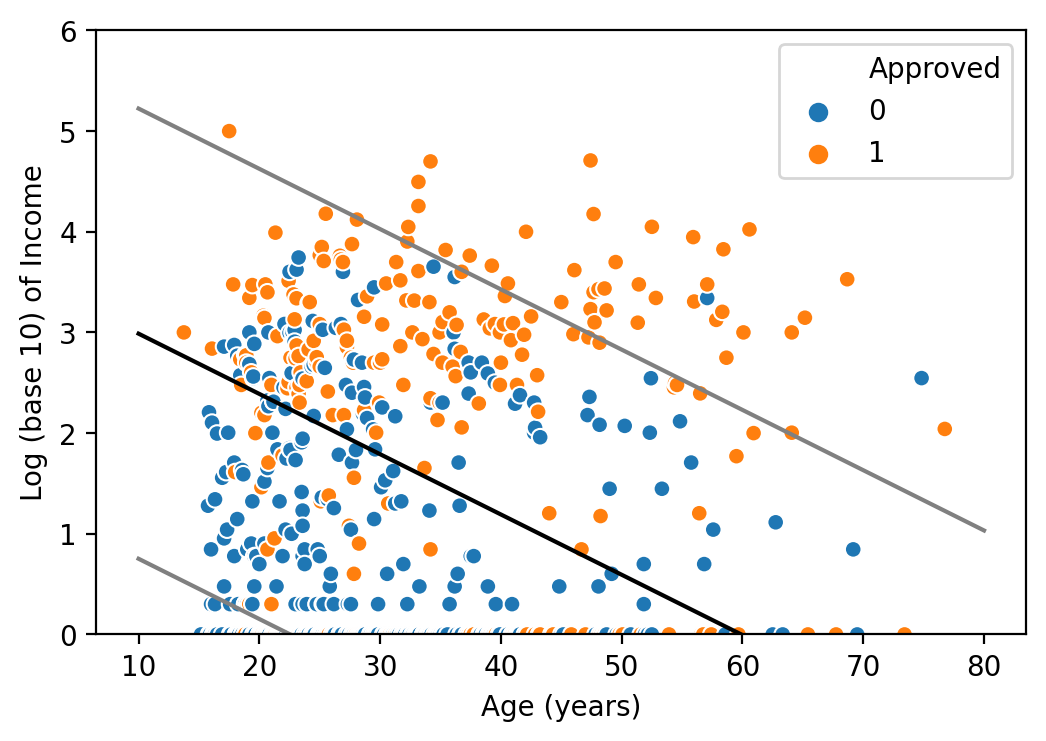

In [20]:
sns.scatterplot('Age', 'LogIncome', hue='Approved', data=credit_sorted)
x1 = np.arange(10, 90, 10)
beta0 = logr.intercept_
beta1 = logr.coef_[0][0]
beta2 = logr.coef_[0][1]
c = 0
x2 = (c - beta0-beta1*x1)/beta2
plt.plot(x1, x2, color='black')
c = np.log(3)
x2 = (c - beta0-beta1*x1)/beta2
plt.plot(x1, x2, color='gray')
c = np.log(1/3)
x2 = (c - beta0-beta1*x1)/beta2
plt.plot(x1, x2, color='gray')
plt.ylim([0, 6])
plt.xlabel('Age (years)')
plt.ylabel('Log (base 10) of Income')


plt.savefig('credit-age-logincome-decision-boundary.pdf')
plt.savefig('credit-age-logincome-decision-boundary.png')

### Scaled Logistic regression

In [21]:
logr_scaled = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
logr_scaled.fit(X, y)
# np.exp(clf.coef_)[0]
# clf.coef_
logr_scaled.score(X, y)

0.6768759571209801

### Comparison with KNN

In [22]:
k = 15
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X, y)
neigh.score(X, y)

0.6875957120980092

### KNN  scaled

In [23]:
k = 11
neigh_scaled = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=k))])
neigh_scaled.fit(X, y)
neigh_scaled.score(X, y)

0.7289433384379785

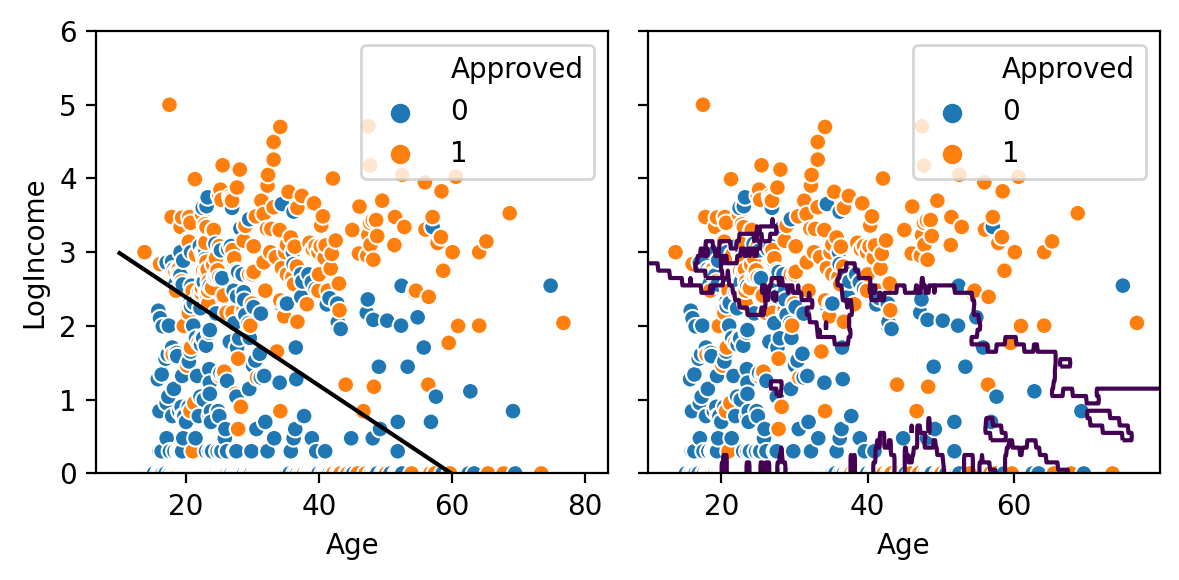

In [24]:
x_min, x_max = 10, 80
y_min, y_max =  0,  6
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(6, 3))
plt.sca(ax[0])
sns.scatterplot('Age', 'LogIncome', hue='Approved', data=credit_sorted)

C = logr.predict(np.c_[xx.ravel(), yy.ravel()])
C = C.reshape(xx.shape)
# plt.contour(xx, yy, C, levels=[0.5])
x2 = (0 - beta0-beta1*x1)/beta2
plt.plot(x1, x2, color='black')
plt.ylim([0, 6])
plt.sca(ax[1])
sns.scatterplot('Age', 'LogIncome', hue='Approved', data=credit_sorted)

C = neigh_scaled.predict(np.c_[xx.ravel(), yy.ravel()])
C = C.reshape(xx.shape)
plt.contour(xx, yy, C, levels=[0.5])
plt.tight_layout()

plt.savefig('logistic-knn.png')
plt.savefig('logistic-knn.pdf')

## Boostrapping confidence intervals
We'll go back to the age and employment example.

In [25]:
k = 1000
n = len(credit_sorted)

beta0star = np.zeros(k)
beta1star = np.zeros(k)
beta2star = np.zeros(k)

for i in range(k):
    credit_sample = credit_sorted.sample(n, replace=True)
    X = credit_sample[['Age', 'Employed']].to_numpy(copy=True) 
    y = credit_sample['Approved'].to_numpy()
    clf = LogisticRegression().fit(X, y)
    beta0star[i] = clf.intercept_[0]
    beta1star[i] = clf.coef_[0][0]
    beta2star[i] = clf.coef_[0][1]
  
Odds_star = pd.Series(np.exp(beta0star))
OR_age_star = pd.Series(np.exp(beta1star))
OR_employment_star = pd.Series(np.exp(beta2star))

In [26]:
Odds_star.quantile([0.05, 0.95])

0.05    0.082492
0.95    0.220496
dtype: float64

In [27]:
OR_age_star.quantile([0.05, 0.95])

0.05    1.016909
0.95    1.044830
dtype: float64

In [28]:
OR_employment_star.quantile([0.05, 0.95])

0.05    4.927081
0.95    8.798960
dtype: float64

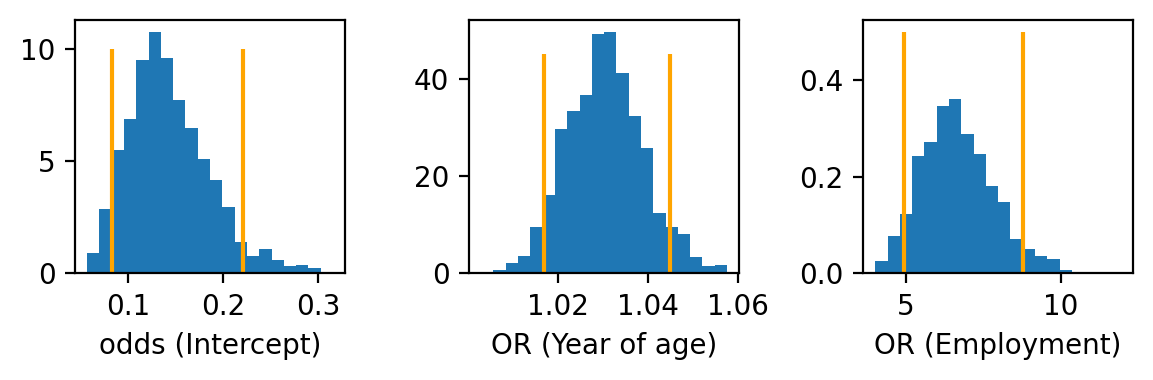

In [29]:
plt.figure(figsize=[6,2])

plt.subplot(1, 3, 1)
plt.hist(np.exp(beta0star), bins=20, density=True)
plt.xlabel('odds (Intercept)')
plt.vlines(Odds_star.quantile([0.05, 0.95]), 0, 10, color='orange')


plt.subplot(1, 3, 2)
plt.hist(np.exp(beta1star), bins=20, density=True)
plt.xlabel('OR (Year of age)')
plt.vlines(OR_age_star.quantile([0.05, 0.95]), 0, 45, color='orange')

plt.subplot(1, 3, 3)
plt.hist(np.exp(beta2star), bins=20, density=True)
plt.vlines(OR_employment_star.quantile([0.05, 0.95]), 0, 0.5, color='orange')

plt.xlabel('OR (Employment)')


plt.tight_layout()
plt.savefig('credit-employment-age-bootstrap.pdf')
plt.savefig('credit-employment-age-bootstrap.png')

## Making logistic regression transparent

In [30]:
credit_sorted.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,DriversLicense,Citizen,Approved,LogIncome,LogCreditScore
510,1.0,13.75,4.000,y,p,w,v,1.750,t,1,t,g,1,3.000434,1.098612
390,1.0,15.17,7.000,u,g,e,v,1.000,f,0,f,g,0,0.000000,0.000000
658,0.0,15.75,0.375,u,g,c,v,1.000,f,0,f,g,0,1.278754,0.000000
651,0.0,15.83,7.625,u,g,q,v,0.125,f,1,t,g,0,2.206826,0.693147
25,0.0,15.83,0.585,u,g,c,h,1.500,t,1,f,g,1,0.000000,1.098612


In [31]:
X = credit_sorted[['Employed', 'Age', 'LogIncome']].to_numpy(copy=True) 
y = credit_sorted['Approved'].to_numpy()
logr = LogisticRegression(random_state=0).fit(X, y)
logr.coef_
# logr.score(X, y)

print("If you are in employment you score %2.3f, if not you score 0"%(logr.coef_[0][0]))
print("Multiply your age by %2.3f and add the result to your score"%(logr.coef_[0][1]))
print("Round your income to the nearest 1000. Multiply the number of zeros in this figure by %2.3f and add the result to your score"%(logr.coef_[0][2]))
print("If you scored more than %2.3f, your credit will be approved"%(-logr.intercept_))

-logr.intercept_


If you are in employment you score 1.625, if not you score 0
Multiply your age by 0.029 and add the result to your score
Round your income to the nearest 1000. Multiply the number of zeros in this figure by 0.320 and add the result to your score
If you scored more than 2.246, your credit will be approved


array([2.24610719])

## Logistic regression on full dataset



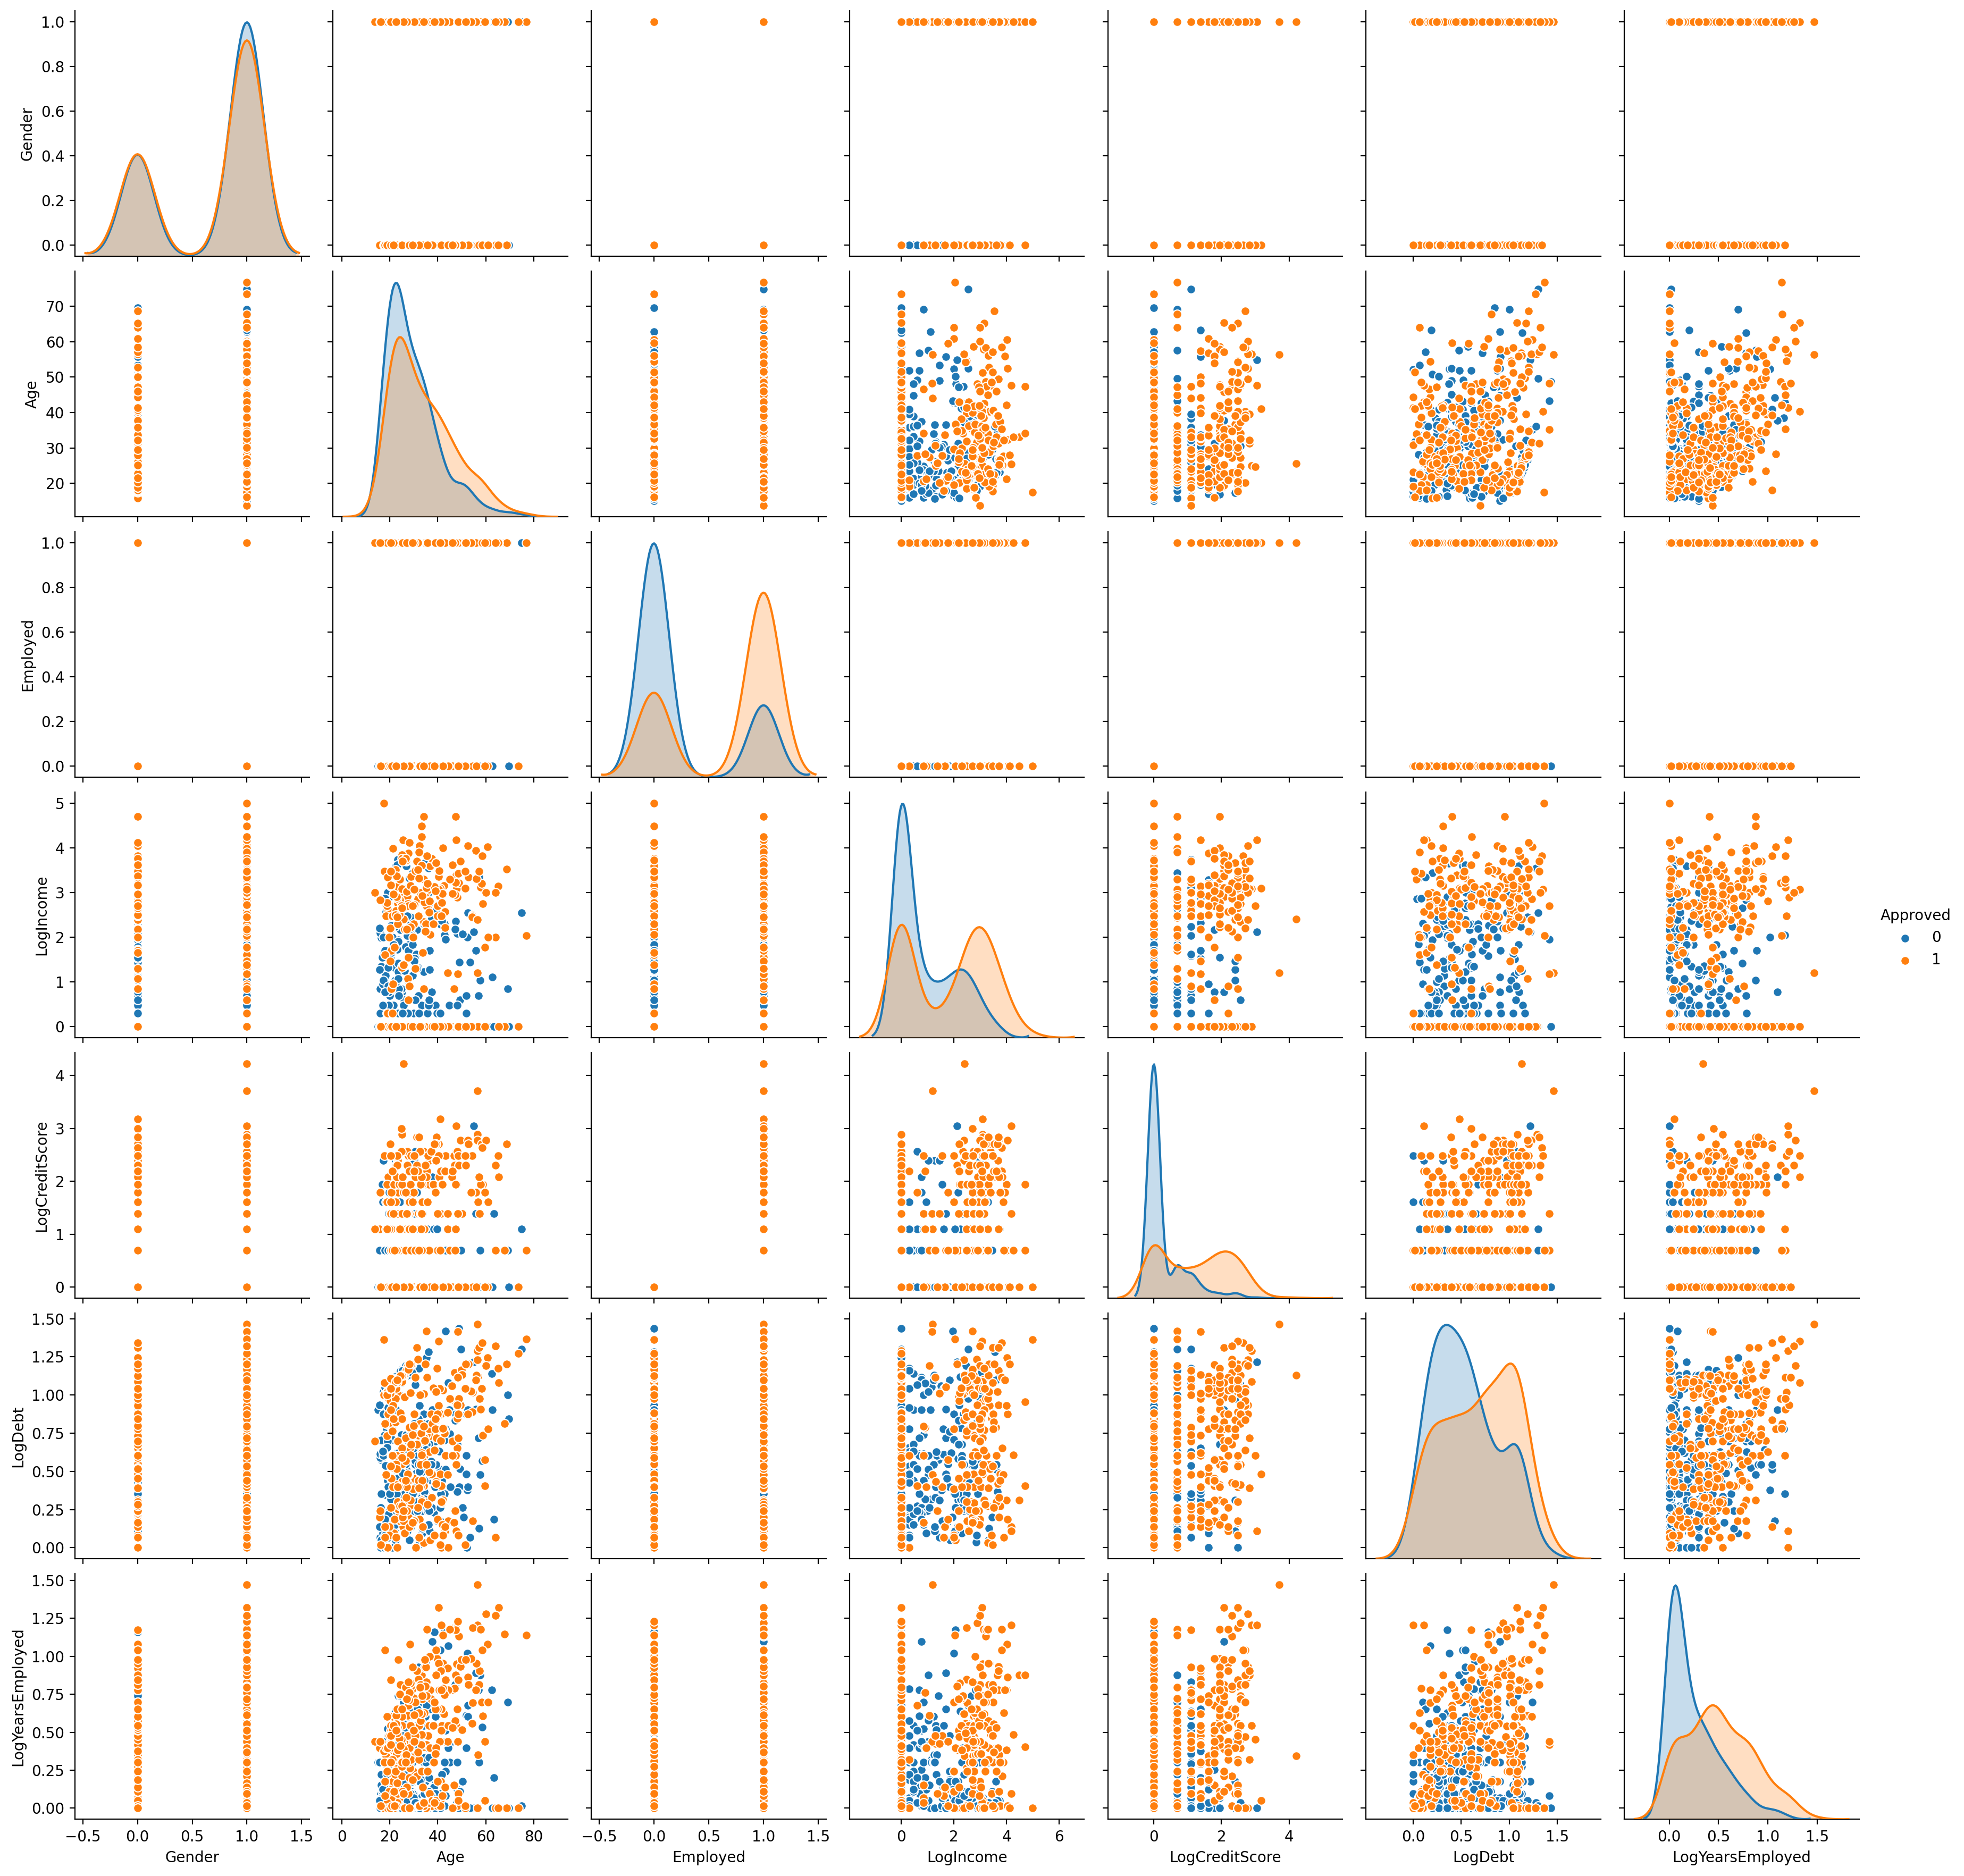

In [32]:
credit_full = credit.drop(['Citizen', 'DriversLicense', 'PriorDefault', 'EducationLevel', 'Ethnicity', 'BankCustomer', 'Married'], 1) 
credit_full['LogDebt'] = np.log10(credit_full['Debt'] + 1)
credit_full['LogYearsEmployed'] = np.log10(credit_full['YearsEmployed'] + 1)

credit_full.drop(['Debt'], 1, inplace=True)
credit_full.drop(['YearsEmployed'], 1, inplace=True)

sns.pairplot(credit_full, hue='Approved')


In [33]:
X_gender = credit_full.drop(['Approved'], 1).to_numpy(copy=True) 
y = credit['Approved'].to_numpy()

logr_gender = LogisticRegression(random_state=0).fit(X_gender, y)

coeffs_gender = pd.Series({'Intercept': logr_gender.intercept_})
coeffs_gender = coeffs_gender.append(pd.Series(logr_gender.coef_[0], index=credit_full.columns.drop('Approved')))

logr_gender.score(X_gender, y)

0.7687595712098009

In [34]:
coeffs_gender

Intercept           [-2.3976810658130905]
Gender                         -0.0338514
Age                            0.00544254
Employed                        -0.156618
LogIncome                        0.317442
LogCreditScore                    1.16387
LogDebt                          0.357915
LogYearsEmployed                   2.0621
dtype: object

In [35]:
X_nogender = credit_full.drop(['Approved', 'Gender'], 1).to_numpy(copy=True) 
y = credit['Approved'].to_numpy()

logr_nogender = LogisticRegression(random_state=0).fit(X_nogender, y)

coeffs_nogender = pd.Series({'Intercept': logr_nogender.intercept_})
coeffs_nogender = coeffs_nogender.append(pd.Series(logr_nogender.coef_[0], index=credit_full.columns.drop(['Approved', 'Gender'])))

logr_nogender.score(X_nogender, y)

0.7672281776416539

In [36]:
coeffs_nogender

Intercept           [-2.4236334735115874]
Age                            0.00548969
Employed                         -0.16109
LogIncome                         0.31739
LogCreditScore                    1.16871
LogDebt                           0.36477
LogYearsEmployed                  2.05154
dtype: object

In [37]:
personA = pd.Series({'Gender': 1,
                     'Age': 30,
                     'Employed': 1,
                     'LogIncome': 3.1,
                     'LogCreditScore': 0,
                     'LogDebt': 0, 
                     'LogYearsEmployed': np.log10(5)})

personB = personA.copy()
personB['Gender'] = 0

np.sum(personA * coeffs_nogender.drop('Intercept')) + coeffs_nogender['Intercept']
np.sum(personB * coeffs_nogender.drop('Intercept')) + coeffs_nogender['Intercept']

array([-0.0021576])

In [38]:
print(np.sum(personA * coeffs_gender.drop('Intercept')) + coeffs_nogender['Intercept'])
print(np.sum(personB * coeffs_gender.drop('Intercept')) + coeffs_nogender['Intercept'])

[-0.02541391]
[0.00843745]


In [39]:
# logr_gender.intercept_ = logr_gender.intercept_ + 1

logr_nogender.intercept_ = logr_nogender.intercept_ + 1

credit_full['ApprovedLRgender'] = logr_gender.predict(X_gender)
credit_full['ApprovedLRnogender'] = logr_nogender.predict(X_nogender)


In [40]:
credit_full.groupby('Gender').mean()

,Age,Employed,Approved,LogIncome,LogCreditScore,LogDebt,LogYearsEmployed,ApprovedLRgender,ApprovedLRnogender
Gender,,,,,,,,,
0.0,30.760985,0.487685,0.467980,1.396869,0.781325,0.642917,0.331740,0.379310,0.660099
1.0,31.838911,0.417778,0.446667,1.259342,0.678348,0.603010,0.382364,0.368889,0.608889
